# Tucson Crossing: Mexico
- Four SSP Scenarios
- Saving output DF and Graphs

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Imputting libraries
from sklearn.linear_model import LinearRegression

# Saving Model Summaries
import statsmodels.api as sm

# Formatting printing and floats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

# Parsing into a dataframe
wide_df = pd.read_csv('INPUTS_OUTPUTS_NEW_VARIABLES_ML/INPUT_DATA_SCRIPT_ML/Mexico/MEX_USA_FINAL_VARS.csv')

# Dropping columns
cols_out = ['CSV', 'Country', 'New_Data_Type']
wide_df = wide_df.drop(cols_out, axis=1).copy()

# Cleaning/parsing
wide_df.iloc[:, 4:] = wide_df.iloc[:, 4:].replace(0, np.nan)  # Replacing all 0 values with NaN values
wide_df.iloc[:, 4:] = wide_df.iloc[:, 4:].astype(float)       # Data type to float 

In [2]:
wide_df

,Type_of_Variable,Country_Code,Variable,Unit_of_Measure,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,TRAC,MEX,MEX_Rio_Grande,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27992.00,90597.00,78281.00,66178.00,58652.00,53760.00,49755.00,47106.00,43577.00,40574.00,37307.00,33934.00,30402.00,28114.00,25153.00,10837.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAC,MEX,MEX_Tucson,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50084.00,294358.00,238808.00,173228.00,108440.00,102567.00,99862.00,61154.00,48575.00,44506.00,23426.00,29263.00,30867.00,57478.00,135042.00,87759.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TRAC,MEX,MEX_San_Diego,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26395.00,158512.00,107218.00,63967.00,36978.00,26245.00,26797.00,27791.00,23520.00,26184.00,18766.00,27038.00,34462.00,59848.00,124296.00,55641.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SSP SCENARIO,MEX,MEX_SSP119_avg_temp,Degrees Celsius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.57,19.64,18.94,19.14,19.47,19.98,19.48,19.59,19.41,19.59,19.72,19.70,19.89,19.74,20.13,19.89,19.67,19.35,19.21,19.76,19.55,19.48,20.05,19.62,19.81,19.96,19.98,19.50,19.35,20.30,19.92,19.54,19.97,19.95,19.95,19.99,19.81,19.56,19.77,19.80,19.96,19.93,19.82,19.83,19.26,19.43,19.82,19.50,19.66,19.63,19.94,19.37,19.72,19.21,19.62,19.41,19.81,19.52,19.28,19.85,19.31,19.83,18.83,19.90,19.63,19.08,19.34,19.57,19.69,19.63,19.51,19.34,19.83,19.15,19.54,19.59,19.46,19.53,19.37,19.65,19.70,19.41,19.38,19.39,19.35,19.14
4,SSP SCENARIO,MEX,MEX_SSP245_avg_temp,Degrees Celsius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.59,19.63,19.32,19.97,19.87,19.80,19.82,19.62,19.86,19.85,19.59,19.78,19.84,19.83,20.16,19.92,20.35,19.99,19.77,19.81,19.47,19.94,19.06,

In [3]:
# Function to parse data into numeric

def prepare_data(df, year_columns):
    df[year_columns] = df[year_columns].apply(pd.to_numeric, errors='coerce')
    return df

# # Function to impute data with OLS

def impute_with_ols(df, train_start_year, train_end_year):
    # Defining columns
    year_columns = [str(year) for year in range(train_start_year, train_end_year + 1)]
    # Imputting data
    for index, row in df.iterrows():
        # Fitting the model only on available data
        available_data = row[year_columns].dropna()
        if len(available_data) < 2:
            continue  # Need at least two data points to fit a line
        
        # Determining imputation method for each variable
        impute_method = {}
        for col in available_data.index:
            if col in ['GDP (current US$)', 'GDP per capita (current US$)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']:
                impute_method[col] = 'mean'
            else:
                impute_method[col] = 'median'

        # Setting variables for OLS
        X_train = np.array(list(map(int, available_data.index))).reshape(-1, 1)
        y_train = available_data.values
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predicting missing values
        missing_years = row[year_columns][row[year_columns].isna()].index
        if missing_years.empty:
            continue
        X_missing = np.array(list(map(int, missing_years))).reshape(-1, 1)
        predicted_values = model.predict(X_missing)
        
        # Filling missing values in the DataFrame using the appropriate imputation method
        for col in missing_years:
            if col in impute_method:
                if impute_method[col] == 'mean':
                    df.loc[index, col] = row[year_columns].mean()
                elif impute_method[col] == 'median':
                    df.loc[index, col] = row[year_columns].median()

    return df


# Converting year columns to numeric: 1960 - 2100

year_columns = [str(year) for year in range(1960, 2100)]
wide_df = prepare_data(wide_df, year_columns)

In [4]:
wide_df.tail()

,Type_of_Variable,Country_Code,Variable,Unit_of_Measure,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
24,POPULATION VARIABLE,USA,Prevalence of undernourishment (% of population),Share of Population,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3528128.93,3230717.55,2926099.15,2614705.59,2626639.62,2320580.58,2324220.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,POPULATION VARIABLE,USA,Corruption,Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15700.00,16200.00,15900.00,15900.00,15967.00,14765.00,13497.00,9393.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,POPULATION VARIABLE,USA,Government Effectiveness: Estimate,Rate (0 to 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.52,NaN,1.70,NaN,1.72,NaN,1.62,1.54,1.74,1.53,1.58,1.64,1.61,1.50,1.55,1.51,1.52,1.52,1.46,1.43,1.44,1.52,1.54,1.45,1.28,1.30,1.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,ECONOMIC VARIABLE,USA,GDP (current US$),USD,543000000000.00,563000000000.00,605000000000.00,639000000000.00,686000000000.00,744000000000.00,815000000000.00,862000000000.00,943000000000.00,1020000000000.00,1070000000000.00,1160000000000.00,1280000000000.00,1430000000000.00,1550000000000.00,1680000000000.00,1870000000000.00,2080000000000.00,2350000000000.00,2630000000000.00,2860000000000.00,3210000000000.00,3340000000000.00,3630000000000.00,4040000000000.00,4340000000000.00,4580000000000.00,4860000000000.00,5240000000000.00,5640000000000.00,5960000000000.00,6160000000000.00,6520000000000.00,6860000000000.00,7290000000000.00,7640000000000.00,8070000000000.00,8580000000000.00,9060000000000.00,9630000000000.00,10300000000000.00,10600000000000.00,10900000000000.00,11500000000000.00,12200000000000.00,13000000000000.00,13800000000000.00,14500000000000.00,14800000000000.00,14500000000000.00,15000000000000.00,15600000000000.00,16300000000000.00,16800000000000.00,17600000000000.00,18200000000000.00,18700000000000.00,19500000000000.00,20500000000000.00,21400000000000.00,21100000000000.00,23300000000000.00,25400000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [5]:
# OLS : 2015 TO 2022

# Perform imputation with OLS for specified years
wide_df_processed_data_ols = impute_with_ols(wide_df, 2015, 2022)
wide_df_processed_data_ols = wide_df_processed_data_ols

# Dropping columns
years_to_drop = [str(year) for year in range(1960, 2015)]
wide_df_processed_data_ols = wide_df_processed_data_ols.drop(columns=years_to_drop)
# wide_df_processed_data_ols.head()

In [6]:
# Function to parse data into numeric

def convert_to_numeric(df):
    for col in df.columns:
        try:
            # Force convert to float and handle exceptions
            df[col] = pd.to_numeric(df[col], errors='raise')
        except ValueError as e:
            # Log columns that could not be converted, with error message
            print(f"Column {col} cannot be converted to numeric: {e}")
        except Exception as e:
            # Log unexpected exceptions
            print(f"Unexpected error with column {col}: {e}")
    return df

# Function for Linear Interpolation

def linear_interpolation2(df, start_year, end_year):
    # Create a list of year columns
    year_columns = [str(year) for year in range(start_year, end_year + 1)]
    # Filter out columns that are not in the year range
    year_columns = [col for col in year_columns if col in df.columns]

    # Convert all potential year columns to numeric
    df[year_columns] = convert_to_numeric(df[year_columns])

    # Apply linear interpolation to only the year columns
    df[year_columns] = df[year_columns].interpolate(method='linear', axis=1, limit_direction='both')

    return df

# Calling function with specified years

wide_df_processed_data_ols = linear_interpolation2(wide_df_processed_data_ols, 1960, 2022)
# wide_df_processed_data_ols

/var/folders/n9/h_xmdzn54836zt3_ch46ywdm0000gn/T/ipykernel_10542/4089097305.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='raise')


In [7]:
# wide_df_processed_data_ols['Type__of_Variable'][7:]

In [8]:
# Melting the dataframe

long_df = pd.melt(wide_df_processed_data_ols, id_vars=['Country_Code', 'Variable', 
                                                       'Unit_of_Measure', 'Type_of_Variable'],
                                                         var_name='Year', value_name='Value')

# Printing melted dataframe 
long_df['Year'] = long_df['Year'].astype(int) 
long_df_22to100 = long_df[long_df['Year'] >= 2021]

In [9]:
long_df.head(100)

,Country_Code,Variable,Unit_of_Measure,Type_of_Variable,Year,Value
0,MEX,MEX_Rio_Grande,Person,TRAC,2015,43577.00
1,MEX,MEX_Tucson,Person,TRAC,2015,48575.00
2,MEX,MEX_San_Diego,Person,TRAC,2015,23520.00
3,MEX,MEX_SSP119_avg_temp,Degrees Celsius,SSP SCENARIO,2015,19.57
4,MEX,MEX_SSP245_avg_temp,Degrees Celsius,SSP SCENARIO,2015,19.59
5,MEX,MEX_SSP370_avg_temp,Degrees Celsius,SSP SCENARIO,2015,19.37
6,MEX,MEX_SSP585_avg_temp,Degrees Celsius,SSP SCENARIO,2015,19.89
7,MEX,"Population, total",Person,POPULATION VARIABLE,2015,15567419.00
8,MEX,Rural population (% of total population),Share of Population,POPULATION VARIABLE,2015,7788224.05
9,MEX,Population ages 15-64 (% of total population),Share of Population,POPULATION VARIABLE,2015,9250085.67


In [10]:
# Libraries

import statsmodels.api as sm
# from sklearn.datasets import load_iris 
from math import log
import statsmodels.api as sm
# from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Filter data for temperature projections and historical data

# Historical Data from 1960 to 2022
historical_data = long_df[long_df['Year'] <= 2022]
# Predicted Data from 2022 to 2100
predicted_data = long_df[long_df['Year'] >= 2023]

In [11]:
##################################################################

# Scenario 1: MEX_SSP119_avg_temp
# features_1960_2022_ssp119

# Creating a dataframe 'features_1960_2022_ssp119' 
# Years 1960 to 2022
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'features_ssp119' = X

# Filtering data for 'MEX_SSP119_avg_temp'
MEX_features_1960_2022_ssp119 = historical_data[historical_data['Variable'] == 'MEX_SSP119_avg_temp'] 
MEX_features_1960_2022_ssp119 = MEX_features_1960_2022_ssp119[['Year', 'Value']]                            
MEX_features_1960_2022_ssp119 = MEX_features_1960_2022_ssp119.rename(columns={'Value': 'Temperature'})      

##################################################################

# Scenario 2: MEX_SSP245_avg_temp
# features_1960_2022_ssp245

# Creating a dataframe 'features_1960_2022_ssp245' 
# Years 1960 to 2022
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'features_ssp119' = X

# Filtering data for 'MEX_SSP245_avg_temp'
MEX_features_1960_2022_ssp245 = historical_data[historical_data['Variable'] == 'MEX_SSP245_avg_temp'] 
MEX_features_1960_2022_ssp245 = MEX_features_1960_2022_ssp245[['Year', 'Value']]                            
MEX_features_1960_2022_ssp245 = MEX_features_1960_2022_ssp245.rename(columns={'Value': 'Temperature'})      

##################################################################

# Scenario 3: MEX_SSP370_avg_temp
# features_1960_2022_ssp370

# Creating a dataframe 'features_1960_2022_ssp370' 
# Years 1960 to 2022
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'features_ssp119' = X

# Filtering data for 'MEX_SSP245_avg_temp'
MEX_features_1960_2022_ssp370 = historical_data[historical_data['Variable'] == 'MEX_SSP370_avg_temp'] 
MEX_features_1960_2022_ssp370 = MEX_features_1960_2022_ssp370[['Year', 'Value']]                            
MEX_features_1960_2022_ssp370 = MEX_features_1960_2022_ssp370.rename(columns={'Value': 'Temperature'})      

##################################################################

# Scenario 4: MEX_SSP585_avg_temp
# features_1960_2022_ssp585

# Creating a dataframe 'features_1960_2022_ssp585' 
# Years 1960 to 2022
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'features_ssp119' = X

# Filtering data for 'MEX_SSP585_avg_temp'
MEX_features_1960_2022_ssp585 = historical_data[historical_data['Variable'] == 'MEX_SSP585_avg_temp'] 
MEX_features_1960_2022_ssp585 = MEX_features_1960_2022_ssp585[['Year', 'Value']]                            
MEX_features_1960_2022_ssp585 = MEX_features_1960_2022_ssp585.rename(columns={'Value': 'Temperature'})      

##################################################################

# Additional Variables to all models
# additional_variables: not considering SSP and TRAC data: X
additional_variables = [
    'Population, total',
    'Rural population (% of total population)',
    'Population ages 15-64 (% of total population)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Victims of intentional homicide',
    'Prevalence of severe food insecurity in the population (%)',
    'Prevalence of undernourishment (% of population)',
    'Corruption',
    'Government Effectiveness: Estimate',
    'GDP (current US$)',
    'GDP per capita (current US$)'
]
    
##################################################################

##################################################################

# Scenario 1: _SSP119_avg_temp
# features_1960_2022_ssp119
# Getting all values from additional_variables into features
for var in additional_variables:
    var_data = historical_data[historical_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_features_1960_2022_ssp119 = pd.merge(MEX_features_1960_2022_ssp119, var_data, on='Year', how='outer') 
    
# features_1960_2022_ssp119.tail() 
##################################################################

# Scenario 2: _SSP245_avg_temp
# features_1960_2022_ssp245
# Getting all values from additional_variables into features
for var in additional_variables:
    var_data = historical_data[historical_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_features_1960_2022_ssp245 = pd.merge(MEX_features_1960_2022_ssp245, var_data, on='Year', how='outer') #CHANGE!!!!!!!!!!!
    
# features_1960_2022_ssp245.tail() 
##################################################################

# Scenario 3: _SSP370_avg_temp
# features_1960_2022_ssp370
# Getting all values from additional_variables into features
for var in additional_variables:
    var_data = historical_data[historical_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_features_1960_2022_ssp370 = pd.merge(MEX_features_1960_2022_ssp370, var_data, on='Year', how='outer') #CHANGE!!!!!!!!!!!
    
# features_1960_2022_ssp370.tail() 
##################################################################

# Scenario 4: _SSP585_avg_temp
# features_1960_2022_ssp585
# Getting all values from additional_variables into features
for var in additional_variables:
    var_data = historical_data[historical_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_features_1960_2022_ssp585 = pd.merge(MEX_features_1960_2022_ssp585, var_data, on='Year', how='outer') #CHANGE!!!!!!!!!!!

# features_1960_2022_ssp585.head() 

In [12]:
# MEX_features_1960_2022_ssp119

In [13]:
# Libraries 

from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

In [14]:
# Historic data on temperature
X1_119_MEX = MEX_features_1960_2022_ssp119[['Temperature']]         
# Predictions on training data based on temperature
Y1_119_MEX = MEX_features_1960_2022_ssp119.drop(columns='Temperature')      
# Training model with Ridge Regression for 'MEX_SSP119_avg_temp' based on 'Temperature'
model119_MEX = MultiOutputRegressor(Ridge(random_state=123)).fit(X1_119_MEX, Y1_119_MEX)

In [15]:
# Y1_119_MEX.shape    # Y1_119_MEX.shape # (32768, 14)
# X1_119_MEX.shape # Y1_119_MEX.shape # (32768, 1)
Y1_119_MEX.tail()

,Year,"Population, total",Rural population (% of total population),Population ages 15-64 (% of total population),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Victims of intentional homicide,Prevalence of severe food insecurity in the population (%),Prevalence of undernourishment (% of population),Corruption,Government Effectiveness: Estimate,GDP (current US$),GDP per capita (current US$)
16379,2022,333287557.00,56378923.14,56378923.14,2056703.12,21593.00,2324220.88,2324220.88,9393.00,-0.28,25400000000000.00,76329.58
16380,2022,333287557.00,56378923.14,56378923.14,2056703.12,21593.00,2324220.88,2324220.88,9393.00,1.26,95003330316.00,5473.21
16381,2022,333287557.00,56378923.14,56378923.14,2056703.12,21593.00,2324220.88,2324220.88,9393.00,1.26,95003330316.00,76329.58
16382,2022,333287557.00,56378923.14,56378923.14,2056703.12,21593.00,2324220.88,2324220.88,9393.00,1.26,25400000000000.00,5473.21
16383,2022,333287557.00,56378923.14,56378923.14,2056703.12,21593.00,2324220.88,2324220.88,9393.00,1.26,25400000000000.00,76329.58


In [16]:
model119_MEX

MultiOutputRegressor(estimator=Ridge(random_state=123))

In [17]:
##################################################################
# Training Data: training all features based on temperature

######### Crossing 1: MEX_Tucson #########
# X1 and Y1 are based on features_ssp119 which was filtered with 'MEX_SSP119_avg_temp'

# Historic data on temperature
X1_119_MEX = MEX_features_1960_2022_ssp119[['Temperature']]         
# Predictions on training data based on temperature
Y1_119_MEX = MEX_features_1960_2022_ssp119.drop(columns='Temperature')      
# Training model with Ridge Regression for 'MEX_SSP119_avg_temp' based on 'Temperature'
model119_MEX = MultiOutputRegressor(Ridge(random_state=123)).fit(X1_119_MEX, Y1_119_MEX)

##################################################################
##################################################################
# Training Data: training all features based on temperature

######### Crossing 1: MEX_Tucson #########
# X1 and Y1 are based on features_ssp245 which was filtered with 'MEX_SSP245_avg_temp'

# Historic data on temperature
X2_245_MEX = MEX_features_1960_2022_ssp245[['Temperature']]         
# Predictions on training data based on temperature
Y2_245_MEX = MEX_features_1960_2022_ssp245.drop(columns='Temperature')      
# Training model with Ridge Regression for 'MEX_SSP119_avg_temp' based on 'Temperature'
model245_MEX = MultiOutputRegressor(Ridge(random_state=123)).fit(X2_245_MEX, Y2_245_MEX)

##################################################################
##################################################################
# Training Data: training all features based on temperature

######### Crossing 1: MEX_Tucson #########
# X1 and Y1 are based on features_ssp370 which was filtered with 'MEX_SSP370_avg_temp'

# Historic data on temperature
X3_370_MEX = MEX_features_1960_2022_ssp370[['Temperature']]         
# Predictions on training data based on temperature
Y3_370_MEX = MEX_features_1960_2022_ssp370.drop(columns='Temperature')      
# Training model with Ridge Regression for 'MEX_SSP119_avg_temp' based on 'Temperature'
model370_MEX = MultiOutputRegressor(Ridge(random_state=123)).fit(X3_370_MEX, Y3_370_MEX)

##################################################################
##################################################################
# Training Data: training all features based on temperature

######### Crossing 1: MEX_Tucson #########
# X1 and Y1 are based on features_ssp585 which was filtered with 'MEX_SSP585_avg_temp'

# Historic data on temperature
X4_585_MEX = MEX_features_1960_2022_ssp585[['Temperature']]         
# Predictions on training data based on temperature
Y4_585_MEX = MEX_features_1960_2022_ssp585.drop(columns='Temperature')      
# Training model with Ridge Regression for 'MEX_SSP119_avg_temp' based on 'Temperature'
model585_MEX = MultiOutputRegressor(Ridge(random_state=123)).fit(X4_585_MEX, Y4_585_MEX)

##################################################################

In [18]:
# Prediction Dataframe: 2023 to 2100 (predicted_data)
##################################################################

# Additional Variables to all models
# additional_variables: not considering SSP and TRAC data: X
#####

additional_variables = [
    'Population, total',
    'Rural population (% of total population)',
    'Population ages 15-64 (% of total population)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Victims of intentional homicide',
    'Prevalence of severe food insecurity in the population (%)',
    'Prevalence of undernourishment (% of population)',
    'Corruption',
    'Government Effectiveness: Estimate',
    'GDP (current US$)',
    'GDP per capita (current US$)'
]

#####


# Scenario 1: _SSP119_avg_temp = Y
##################################################################
# Creating a dataframe 'new_features_2023_2100_ssp119' 
# Years 2023 to 2100
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'new_features_2023_2100_ssp119' = X
#####
# Filtering data for 'MEX_SSP119_avg_temp'
MEX_new_features_2023_2100_ssp119 = predicted_data[predicted_data['Variable'] == 'MEX_SSP119_avg_temp']
MEX_new_features_2023_2100_ssp119 = MEX_new_features_2023_2100_ssp119[['Year', 'Value']]  
MEX_new_features_2023_2100_ssp119 = MEX_new_features_2023_2100_ssp119.rename(columns={'Value': 'Temperature'})  
#####
# Loop through each additional variable and merge with X1 DataFrame
# _SSP119_avg_temp
for var in additional_variables:
    var_data = predicted_data[predicted_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_new_features_2023_2100_ssp119 = pd.merge(MEX_new_features_2023_2100_ssp119, var_data, on='Year', how='outer')
##################################################################


# Scenario 2: _SSP245_avg_temp = Y
##################################################################
# Creating a dataframe 'new_features_2023_2100_ssp245' 
# Years 2023 to 2100
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'new_features_2023_2100_ssp245' = X
#####
# Filtering data for 'MEX_SSP245_avg_temp'
MEX_new_features_2023_2100_ssp245 = predicted_data[predicted_data['Variable'] == 'MEX_SSP245_avg_temp']
MEX_new_features_2023_2100_ssp245 = MEX_new_features_2023_2100_ssp245[['Year', 'Value']]  
MEX_new_features_2023_2100_ssp245 = MEX_new_features_2023_2100_ssp245.rename(columns={'Value': 'Temperature'})  
#####
# Loop through each additional variable and merge with X1 DataFrame
# _SSP245_avg_temp
for var in additional_variables:
    var_data = predicted_data[predicted_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_new_features_2023_2100_ssp245 = pd.merge(MEX_new_features_2023_2100_ssp245, var_data, on='Year', how='outer')
##################################################################


# Scenario 3: _SSP370_avg_temp = Y
##################################################################
# Creating a dataframe 'new_features_2023_2100_ssp370' 
# Years 2023 to 2100
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'new_features_2023_2100_ssp370' = X

# Filtering data for 'MEX_SSP370_avg_temp'
MEX_new_features_2023_2100_ssp370 = predicted_data[predicted_data['Variable'] == 'MEX_SSP370_avg_temp']
MEX_new_features_2023_2100_ssp370 = MEX_new_features_2023_2100_ssp370[['Year', 'Value']]  
MEX_new_features_2023_2100_ssp370 = MEX_new_features_2023_2100_ssp370.rename(columns={'Value': 'Temperature'})  
#####
# Loop through each additional variable and merge with X1 DataFrame
# _SSP370_avg_temp
for var in additional_variables:
    var_data = predicted_data[predicted_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_new_features_2023_2100_ssp370 = pd.merge(MEX_new_features_2023_2100_ssp370, var_data, on='Year', how='outer')
##################################################################


# Scenario 4: _SSP585_avg_temp = Y
##################################################################
# Creating a dataframe 'new_features_2023_2100_ssp585' 
# Years 2023 to 2100
# 'features_ssp119' stores all values from all variables except SSP and TRAC data
# 'new_features_2023_2100_ssp585' = X

# Filtering data for 'MEX_SSP585_avg_temp'
MEX_new_features_2023_2100_ssp585 = predicted_data[predicted_data['Variable'] == 'MEX_SSP585_avg_temp']
MEX_new_features_2023_2100_ssp585 = MEX_new_features_2023_2100_ssp585[['Year', 'Value']]  
MEX_new_features_2023_2100_ssp585 = MEX_new_features_2023_2100_ssp585.rename(columns={'Value': 'Temperature'})  
#####
# Loop through each additional variable and merge with X1 DataFrame
# _SSP585_avg_temp
for var in additional_variables:
    var_data = predicted_data[predicted_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    MEX_new_features_2023_2100_ssp585 = pd.merge(MEX_new_features_2023_2100_ssp585, var_data, on='Year', how='outer')

In [19]:
# Predicting all NaN values of the additional_variables

##################################################################
# X2 is getting just the temperature values
# new_features_2023_2100_ssp119
X2_119_MEX = MEX_new_features_2023_2100_ssp119[['Temperature']]
# Here the model is predicting all values and storing them in Y2
Y2_119_MEX = model119_MEX.predict(X2_119_MEX)[:,1:]
# The additional_variables are now getting the predicted Y2 values
MEX_new_features_2023_2100_ssp119[additional_variables] = Y2_119_MEX
##################################################################
# X2 is getting just the temperature values
# new_features_2023_2100_ssp245
X2_245_MEX = MEX_new_features_2023_2100_ssp245[['Temperature']]
# Here the model is predicting all values and storing them in Y2
Y2_245_MEX = model245_MEX.predict(X2_245_MEX)[:,1:]
# The additional_variables are now getting the predicted Y2 values
MEX_new_features_2023_2100_ssp245[additional_variables] = Y2_245_MEX
##################################################################
# X2 is getting just the temperature values
# new_features_2023_2100_ssp370
X2_370_MEX = MEX_new_features_2023_2100_ssp370[['Temperature']]
# Here the model is predicting all values and storing them in Y2
Y2_370_MEX = model370_MEX.predict(X2_370_MEX)[:,1:]
# The additional_variables are now getting the predicted Y2 values
MEX_new_features_2023_2100_ssp370[additional_variables] = Y2_370_MEX
##################################################################
# X2 is getting just the temperature values
# new_features_2023_2100_ssp585
X2_585_MEX = MEX_new_features_2023_2100_ssp585[['Temperature']]
# Here the model is predicting all values and storing them in Y2
Y2_585_MEX = model585_MEX.predict(X2_585_MEX)[:,1:]
# The additional_variables are now getting the predicted Y2 values
MEX_new_features_2023_2100_ssp585[additional_variables] = Y2_585_MEX

# Predicting TRAC from all features

In [20]:
# Filter data for temperature projections and historical data

# Prediction starts from 2015 because TRAC starts on 2015
# long_df goes from 2015 to 2100

# Temperature Data from 2023 to 2100, all four SSPs

# Historical Data from 2015 to 2022
long_hist_data = long_df[long_df['Year'] <= 2022]
# Predicted Data from 2023 to 2100
long_predicted_data = long_df[long_df['Year'] >= 2023]
# Dependent Variables, TRAC Crossings
dep_vars = long_hist_data[long_hist_data['Variable'].isin(['MEX_Rio_Grande', 'MEX_Tucson', 'MEX_Tucson'])]

In [21]:
##################################################################
# Filter data for 'MEX_SSP119_avg_temp'

X1_119_MEX = long_hist_data[long_hist_data['Variable'] == 'MEX_SSP119_avg_temp']
X1_119_MEX = X1_119_MEX[['Year', 'Value']]
X1_119_MEX = X1_119_MEX.rename(columns={'Value': 'Temperature'})
##################################################################
# Filter data for 'MEX_SSP245_avg_temp'

X1_245_MEX = long_hist_data[long_hist_data['Variable'] == 'MEX_SSP245_avg_temp']
X1_245_MEX = X1_245_MEX[['Year', 'Value']]
X1_245_MEX = X1_245_MEX.rename(columns={'Value': 'Temperature'})
##################################################################
# Filter data for 'MEX_SSP370_avg_temp'

X1_370_MEX = long_hist_data[long_hist_data['Variable'] == 'MEX_SSP370_avg_temp']
X1_370_MEX = X1_370_MEX[['Year', 'Value']]
X1_370_MEX = X1_370_MEX.rename(columns={'Value': 'Temperature'})
##################################################################
# Filter data for 'MEX_SSP585_avg_temp'

X1_585_MEX = long_hist_data[long_hist_data['Variable'] == 'MEX_SSP585_avg_temp']
X1_585_MEX = X1_585_MEX[['Year', 'Value']]
X1_585_MEX = X1_585_MEX.rename(columns={'Value': 'Temperature'})
##################################################################

# List of additional variables to add to X1

additional_variables = [
    'Population, total',
    'Rural population (% of total population)',
    'Population ages 15-64 (% of total population)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Victims of intentional homicide',
    'Prevalence of severe food insecurity in the population (%)',
    'Prevalence of undernourishment (% of population)',
    'Corruption',
    'Government Effectiveness: Estimate',
    'GDP (current US$)',
    'GDP per capita (current US$)',
    'MEX_Tucson'
]


##################################################################
# Loop through each additional variable and merge with X1 DataFrame
for var in additional_variables:
    var_data = long_hist_data[long_hist_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    X1_119_MEX = pd.merge(X1_119_MEX, var_data, on='Year', how='outer')
# Now X1 contains 'Temperature' along with the additional variables for each year
# 2015 to 2022
##################################################################
# Loop through each additional variable and merge with X1 DataFrame
for var in additional_variables:
    var_data = long_hist_data[long_hist_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    X1_245_MEX = pd.merge(X1_245_MEX, var_data, on='Year', how='outer')
# Now X1 contains 'Temperature' along with the additional variables for each year
# 2015 to 2022
##################################################################
# Loop through each additional variable and merge with X1 DataFrame
for var in additional_variables:
    var_data = long_hist_data[long_hist_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    X1_370_MEX = pd.merge(X1_370_MEX, var_data, on='Year', how='outer')
# Now X1 contains 'Temperature' along with the additional variables for each year
# 2015 to 2022
##################################################################
# Loop through each additional variable and merge with X1 DataFrame
for var in additional_variables:
    var_data = long_hist_data[long_hist_data['Variable'] == var][['Year', 'Value']]
    var_data = var_data.rename(columns={'Value': var})
    X1_585_MEX = pd.merge(X1_585_MEX, var_data, on='Year', how='outer')
# Now X1 contains 'Temperature' along with the additional variables for each year

In [22]:
##################################################################
# _SSP119_avg_temp
X1_119_new_MEX = X1_119_MEX[X1_119_MEX['Year'] >= 2015]
##################################################################
# _SSP245_avg_temp
X1_245_new_MEX = X1_245_MEX[X1_245_MEX['Year'] >= 2015]
##################################################################
# _SSP370_avg_temp
X1_370_new_MEX = X1_370_MEX[X1_370_MEX['Year'] >= 2015]
##################################################################
# _SSP585_avg_temp
X1_585_new_MEX = X1_585_MEX[X1_585_MEX['Year'] >= 2015]

In [23]:
# X1_119_new_MEX.head()

# Predicting Tucson Crossings

In [24]:
##################################################################
# Predicting Y: _SSP119_avg_temp
Y1_119_MEX = X1_119_new_MEX[['MEX_Tucson']]
X1_predict_119_MEX = X1_119_new_MEX.drop(columns='MEX_Tucson')
##################################################################
# Predicting Y: _SSP245_avg_temp
Y1_245_MEX = X1_245_new_MEX[['MEX_Tucson']]
X1_predict_245_MEX = X1_245_new_MEX.drop(columns='MEX_Tucson')
##################################################################
# Predicting Y: _SSP370_avg_temp
Y1_370_MEX = X1_370_new_MEX[['MEX_Tucson']]
X1_predict_370_MEX = X1_370_new_MEX.drop(columns='MEX_Tucson')
##################################################################
# Predicting Y: _SSP585_avg_temp
Y1_585_MEX = X1_585_new_MEX[['MEX_Tucson']]
X1_predict_585_MEX = X1_585_new_MEX.drop(columns='MEX_Tucson')

In [25]:
print(X1_predict_119_MEX.isnull().sum())
print(X1_predict_119_MEX.isin([np.nan, np.inf, -np.inf]).sum())


Year                                                                   0
Temperature                                                            0
Population, total                                                      0
Rural population (% of total population)                               0
Population ages 15-64 (% of total population)                          0
Unemployment, total (% of total labor force) (modeled ILO estimate)    0
Victims of intentional homicide                                        0
Prevalence of severe food insecurity in the population (%)             0
Prevalence of undernourishment (% of population)                       0
Corruption                                                             0
Government Effectiveness: Estimate                                     0
GDP (current US$)                                                      0
GDP per capita (current US$)                                           0
dtype: int64
Year                                  

# Training on TRAC: MEX_Tucson

In [26]:
# Training on TRAC: Crossing 1: MEX_Tucson

# _SSP119_avg_temp
model1_ssp119_MEX = sm.OLS(Y1_119_MEX, X1_predict_119_MEX).fit()
# _SSP245_avg_temp
model2_ssp245_MEX = sm.OLS(Y1_245_MEX, X1_predict_245_MEX).fit()
# _SSP370_avg_temp
model3_ssp370_MEX = sm.OLS(Y1_370_MEX, X1_predict_370_MEX).fit()
# _SSP585_avg_temp
model4_ssp585_MEX = sm.OLS(Y1_585_MEX, X1_predict_585_MEX).fit()

# Saving Model Summaries

models_and_data = [
    (model1_ssp119_MEX, "Y1_119_MEX", "X1_predict_119_MEX"),
    (model2_ssp245_MEX, "Y1_245_MEX", "X1_predict_245_MEX"),
    (model3_ssp370_MEX, "Y1_370_MEX", "X1_predict_370_MEX"),
    (model4_ssp585_MEX, "Y1_585_MEX", "X1_predict_585_MEX")
]

directory_path = "All_outputs/Mexico"

# Iterate over models and save their summaries
for model, Y_var, X_var in models_and_data:
    fitted_model = sm.OLS(eval(Y_var), eval(X_var)).fit()
    model_name = [name for name, obj in globals().items() if obj is model][0]
    model_name = f"Tucson_{model_name}"
    file_path = f"{directory_path}{model_name}_summary.txt"
    # Save the model summary as a text file
    with open(file_path, "w") as file:
        file.write(str(fitted_model.summary()))

In [27]:
# TRAC prediction 2023 to 2100: _SSP119_avg_temp
predicted_future_imigrants_ssp119_MEX = model1_ssp119_MEX.predict(MEX_new_features_2023_2100_ssp119)
# TRAC prediction 2023 to 2100: _SSP245_avg_temp
predicted_future_imigrants_ssp245_MEX = model2_ssp245_MEX.predict(MEX_new_features_2023_2100_ssp245)
# TRAC prediction 2023 to 2100: _SSP370_avg_temp
predicted_future_imigrants_ssp370_MEX = model3_ssp370_MEX.predict(MEX_new_features_2023_2100_ssp370)
# TRAC prediction 2023 to 2100: _SSP585_avg_temp
predicted_future_imigrants_ssp585_MEX = model4_ssp585_MEX.predict(MEX_new_features_2023_2100_ssp585)

In [28]:
# Printing Dataframe for SSP119
MEX_new_features_2023_2100_ssp119['MEX_Tucson'] = predicted_future_imigrants_ssp119_MEX
# Printing Dataframe for SSP245
MEX_new_features_2023_2100_ssp245['MEX_Tucson'] = predicted_future_imigrants_ssp245_MEX
# Printing Dataframe for SSP370
MEX_new_features_2023_2100_ssp370['MEX_Tucson'] = predicted_future_imigrants_ssp370_MEX
# Printing Dataframe for SSP585
MEX_new_features_2023_2100_ssp585['MEX_Tucson'] = predicted_future_imigrants_ssp585_MEX

In [29]:
##################################################################
# Removing duplicated data per year: _SSP119_avg_temp
years = MEX_new_features_2023_2100_ssp119['Year'].unique()
final_predictions_2023_2100_ssp119_MEX = pd.DataFrame()  
for year in years:
    first_row = MEX_new_features_2023_2100_ssp119[MEX_new_features_2023_2100_ssp119['Year'] == year].iloc[0]  
    final_predictions_2023_2100_ssp119_MEX = pd.concat([final_predictions_2023_2100_ssp119_MEX, pd.DataFrame([first_row])])
final_predictions_2023_2100_ssp119_MEX.reset_index(drop=True, inplace=True)
final_predictions_2023_2100_ssp119_MEX['Year'] = final_predictions_2023_2100_ssp119_MEX['Year'].astype(int)
##################################################################
# Removing duplicated data per year: _SSP245_avg_temp
years = MEX_new_features_2023_2100_ssp245['Year'].unique()
final_predictions_2023_2100_ssp245_MEX = pd.DataFrame()  
for year in years:
    first_row = MEX_new_features_2023_2100_ssp245[MEX_new_features_2023_2100_ssp245['Year'] == year].iloc[0]  
    final_predictions_2023_2100_ssp245_MEX = pd.concat([final_predictions_2023_2100_ssp245_MEX, pd.DataFrame([first_row])])
final_predictions_2023_2100_ssp245_MEX.reset_index(drop=True, inplace=True)
final_predictions_2023_2100_ssp245_MEX['Year'] = final_predictions_2023_2100_ssp245_MEX['Year'].astype(int)
##################################################################
# Removing duplicated data per year: _SSP370_avg_temp
years = MEX_new_features_2023_2100_ssp370['Year'].unique()
final_predictions_2023_2100_ssp370_MEX = pd.DataFrame()  
for year in years:
    first_row = MEX_new_features_2023_2100_ssp370[MEX_new_features_2023_2100_ssp370['Year'] == year].iloc[0]  
    final_predictions_2023_2100_ssp370_MEX = pd.concat([final_predictions_2023_2100_ssp370_MEX, pd.DataFrame([first_row])])
final_predictions_2023_2100_ssp370_MEX.reset_index(drop=True, inplace=True)
final_predictions_2023_2100_ssp370_MEX['Year'] = final_predictions_2023_2100_ssp370_MEX['Year'].astype(int)
##################################################################
# Removing duplicated data per year: _SSP585_avg_temp
years = MEX_new_features_2023_2100_ssp585['Year'].unique()
final_predictions_2023_2100_ssp585_MEX = pd.DataFrame()  
for year in years:
    first_row = MEX_new_features_2023_2100_ssp585[MEX_new_features_2023_2100_ssp585['Year'] == year].iloc[0]  
    final_predictions_2023_2100_ssp585_MEX = pd.concat([final_predictions_2023_2100_ssp585_MEX, pd.DataFrame([first_row])])
final_predictions_2023_2100_ssp585_MEX.reset_index(drop=True, inplace=True)
final_predictions_2023_2100_ssp585_MEX['Year'] = final_predictions_2023_2100_ssp585_MEX['Year'].astype(int)


# Plotting TRAC Predictions

<!-- final_predictions_2023_2100_ssp119
final_predictions_2023_2100_ssp245
final_predictions_2023_2100_ssp370
final_predictions_2023_2100_ssp585 -->

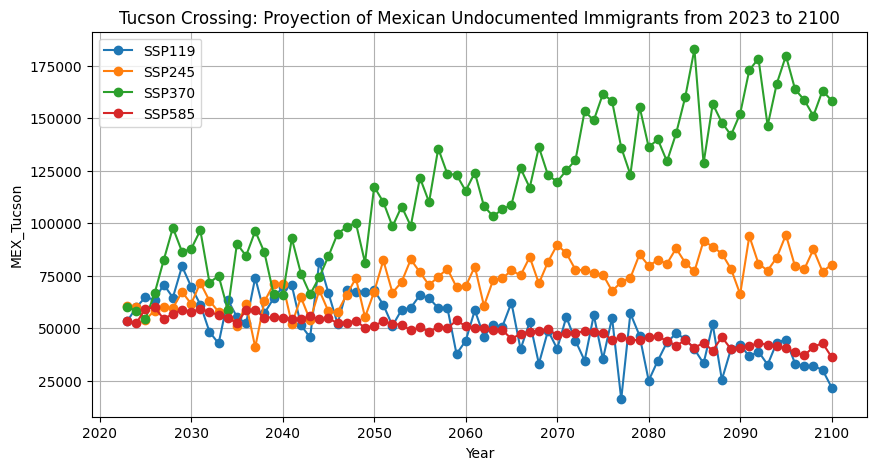

In [30]:
# Setting the index of all DataFrames to 'Year'
final_predictions_2023_2100_ssp119_MEX.set_index('Year', inplace=True)
final_predictions_2023_2100_ssp245_MEX.set_index('Year', inplace=True)
final_predictions_2023_2100_ssp370_MEX.set_index('Year', inplace=True)
final_predictions_2023_2100_ssp585_MEX.set_index('Year', inplace=True)
###########
# Plotting
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
for ssp, label in zip([final_predictions_2023_2100_ssp119_MEX, final_predictions_2023_2100_ssp245_MEX, final_predictions_2023_2100_ssp370_MEX, final_predictions_2023_2100_ssp585_MEX], ['SSP119', 'SSP245', 'SSP370', 'SSP585']):
    plt.plot(ssp.index, ssp['MEX_Tucson'], marker='o', linestyle='-', label=label)
###########
plt.title('Tucson Crossing: Proyection of Mexican Undocumented Immigrants from 2023 to 2100')
plt.xlabel('Year')
plt.ylabel('MEX_Tucson')
plt.grid(True)
plt.legend()

plt.savefig("All_outputs/Mexico/Tucson_MEX_All_Projections.png")

plt.show()

In [31]:
# Function to extract data for each scenario
def extract_data(final_predictions, scenario):
    return pd.DataFrame({
        'Scenario': [scenario] * len(final_predictions),
        'Year': final_predictions.index,
        'Number_of_People': final_predictions['MEX_Tucson']
    })
# Extract data for each scenario
data_ssp119_MEX = extract_data(final_predictions_2023_2100_ssp119_MEX, 'SSP119')
data_ssp245_MEX = extract_data(final_predictions_2023_2100_ssp245_MEX, 'SSP245')
data_ssp370_MEX = extract_data(final_predictions_2023_2100_ssp370_MEX, 'SSP370')
data_ssp585_MEX = extract_data(final_predictions_2023_2100_ssp585_MEX, 'SSP585')
# Concatenating all scenarios into a single DataFrame
output_df_MEX = pd.concat([data_ssp119_MEX, data_ssp245_MEX, data_ssp370_MEX, data_ssp585_MEX], ignore_index=True)
# Pivot the DataFrame
output_df_pivoted_MEX = output_df_MEX.pivot(index='Scenario', columns='Year', values='Number_of_People')
# Fill any missing values with 0
output_df_pivoted_MEX.fillna(0, inplace=True)

# Reformatting dataframe
output_df_pivoted_MEX.insert(0, 'Crossing', 'Tucson_Crossing')
output_df_pivoted_MEX.insert(1, 'Country', 'MEX')

# Saving dataframe

output_df_pivoted_MEX.to_csv("All_outputs/Mexico/Tucson_MEX_4SSP.csv", index=True)

# Printing
output_df_pivoted_MEX

Year,Crossing,Country,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
Scenario,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SSP119,Tucson_Crossing,MEX,53296.74,60027.71,64835.31,63643.39,70839.00,64672.09,79565.02,69838.64,61345.41,48369.98,42828.89,63628.81,55441.74,52359.61,74144.35,57162.16,64233.61,69698.66,70444.75,51466.71,45687.70,81827.89,66853.90,52177.60,68157.92,67235.14,67187.29,68126.57,61215.44,51266.19,58847.02,59810.59,65837.45,64429.21,59658.16,59789.99,37842.84,44067.52,58683.21,46135.02,51824.49,50753.25,62251.76,40104.48,53094.10,33180.21,48949.23,40318.33,55415.64,44136.07,34644.90,56335.94,35396.74,55033.69,16287.17,57130.12,46609.79,25123.04,34651.14,43350.98,47595.99,44999.33,40075.58,33336.44,51879.83,25560.38,40198.05,42063.53,36713.31,38961.31,32711.11,43278.40,44691.58,33231.55,31982.17,32111.30,30272.34,21836.95
SSP245,Tucson_Crossing,MEX,60510.86,60310.36,54057.15,58506.88,59979.85,59643.63,67373.37,61689.45,71661.24,63120.51,57879.35,58853.95,50911.26,61808.61,40996.10,62804.45,70921.34,71292.96,52069.56,64735.58,53876.92,68152.79,58071.01,57806.42,66035.70,73896.45,55302.67,67425.79,82419.63,66944.44,72110.96,82829.47,76696.21,70591.92,74591.82,78333.70,69650.41,69986.92,79427.12,60690.78,72979.78,73767.77,77571.15,75253.73,83950.74,71384.92,81676.46,89772.14,85801.75,77910.89,77691.07,76359.07,75635.94,67785.61,72046.36,74044.79,85242.11,79803.72,82501.98,80818.18,88053.79,81180.16,77089.83,91687.81,88841.62,85605.94,78268.11,66293.26,93936.12,80761.19,77529.28,83734.94,94518.01,79458.96,78113.52,87599.20,77055.35,80333.98
SSP370,Tucson_Crossing,MEX,59947.18,58459.76,54451.38,66630.37,82522.79,97898.45,86456.74,87810.36,96685.70,71716.61,75077.47,58840.32,90244.81,84533.71,96333.26,86191.87,66513.32,65787.81,92813.56,76015.47,66221.04,74318.86,84339.45,95040.52,98340.31,100135.75,81242.51,117404.75,110115.25,98507.63,108004.54,98720.36,121661.04,110092.41,135604.73,123485.56,123112.64,115439.36,124149.22,108136.44,103368.75,106675.90,108774.12,126147.05,116969.43,136269.46,122897.18,119795.83,125194.67,130099.29,153334.52,149001.28,161628.15,158164.68,136050.94,123177.65,155584.47,136267.16,139929.93,129468.00,142784.02,160159.55,182857.67,128567.15,156828.68,147934.77,141983.71,152194.88,172971.53,178363.45,146446.15,166472.15,179751.78,163784.48,158711.85,151139.06,163153.45,158397.45
SSP585,Tucson_Crossing,MEX,53320.69,52444.92,59405.81,59945.58,54512.70,56882.75,58987.35,57936.23,59080.93,57981.38,56237.15,54981.14,52482.55,58694.45,58879.27,55117.29,55313.13,54845.06,54606.84,54625.58,55732.10,54364.50,54717.56,52514.62,52719.30,53640.57,50238.14,51368.42,53291.32,52172.18,51703.83,49053.46,50490.32,48414.15,50615.55,50105.46,53756.27,51087.15,50172.97,50076.93,49195.86,49217.04,45025.26,47415.11,48341.26,48939.29,49535.30,46801.85,47645.97,47790.09,48716.03,48478.93,48018.39,44336.98,45927.93,44651.21,44368.53,45871.67,46293.17,43923.52,41848.46,44293.65,40865.36,43045.08,39470.50,45835.59,40137.60,40747.41,41727.15,42852.06,42281.90,41435.33,40650.50,38587.72,37109.86,41139.39,43036.43,36301.75


# Final Plots

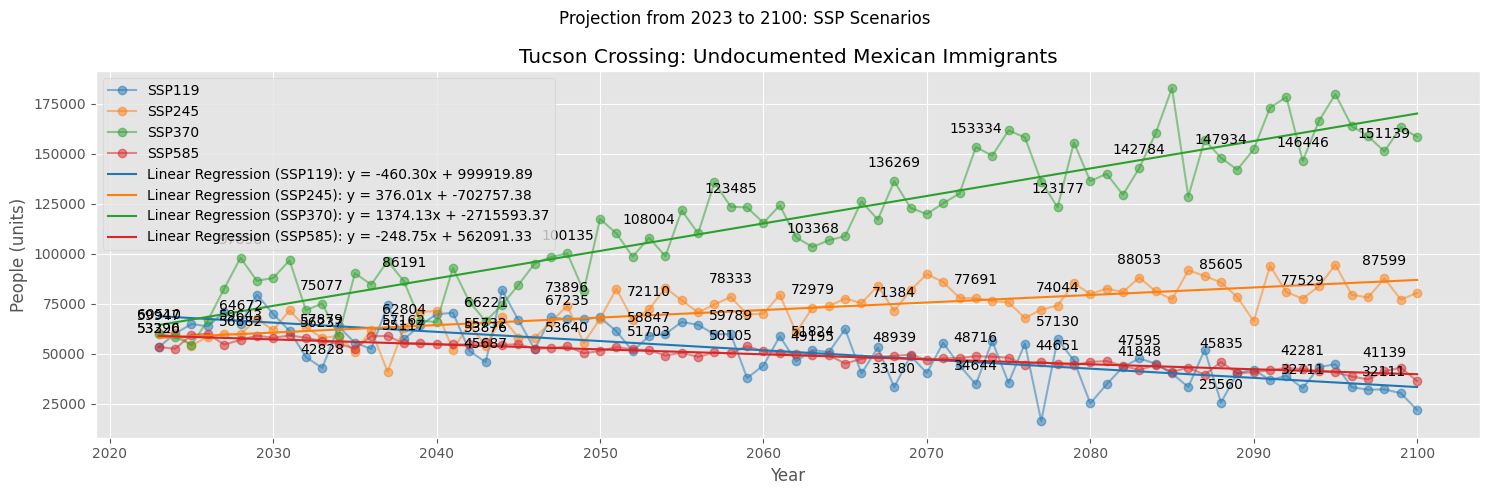

In [32]:
# Plotting results

##################################################################
# Using ggplot
plt.style.use('ggplot')
##################################################################
# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
##################################################################
# Plot size
plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed
##################################################################
# Convert index values to strings
output_df_pivoted_MEX.index = output_df_pivoted_MEX.index.astype(str)
##################################################################
# Selecting every 5th year to display
years_to_display = output_df_pivoted_MEX.columns[2:][::5]  # Excluding first two columns
##################################################################
# Plotting data for each scenario
for scenario, color in zip(output_df_pivoted_MEX.index, colors):
    plt.plot(output_df_pivoted_MEX.columns[2:].astype(int), output_df_pivoted_MEX.loc[scenario][2:], marker='o', linestyle='-', alpha=0.5, label=scenario, color=color)
    for year in years_to_display:
        plt.annotate(f'{int(output_df_pivoted_MEX.loc[scenario, year])}', (int(year), output_df_pivoted_MEX.loc[scenario, year]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Tucson Crossing: Undocumented Mexican Immigrants')
plt.suptitle('Projection from 2023 to 2100: SSP Scenarios')
plt.xlabel('Year')
plt.ylabel('People (units)')
##################################################################
# Linear Regression Equation
X = output_df_pivoted_MEX.columns[2:].astype(int).values.reshape(-1, 1)
for scenario, color in zip(output_df_pivoted_MEX.index, colors):
    y = output_df_pivoted_MEX.loc[scenario][2:].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    m = model.coef_[0][0]
    b = model.intercept_[0]
    plt.plot(output_df_pivoted_MEX.columns[2:].astype(int), m * output_df_pivoted_MEX.columns[2:].astype(int) + b, label=f'Linear Regression ({scenario}): y = {m:.2f}x + {b:.2f}', color=color)
plt.grid(True)
plt.legend()
plt.tight_layout()
##################################################################

# Saving graph
plt.savefig("All_outputs/Mexico/Tucson_MEX_4SSP_Single.png")

plt.show()